In [1]:
import os
import sys
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np

from skimage import io, transform, color
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#Dataset
import torch.utils.data as utils

#Import PyTorch Models
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "models")
sys.path.append(path)
from models import *

#To deepcopy best model
import copy

#Get root path
root_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "Marcel-Train")
f_id = ["A", "B", "C", "Five", "Point", "V"]

#Find files inside the path
files = glob.glob(os.path.join(root_path, "A", "*.ppm"))

C:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


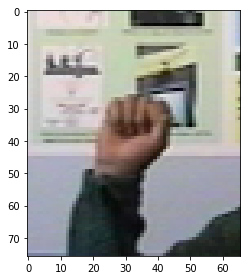

In [2]:
#Show a sample image
img = io.imread("C:/Users/Bilal/git/gesture_recog_toy/Marcel-Train/A/A-train0001.ppm")
io.imshow(img)
plt.show()

In [3]:
#Read train and validation dataset
dataset = []
labels = []

#Go inside each f_id directory
for i in range(len(f_id)):
    #Find image paths
    path = os.path.join(root_path, f_id[i])
    image_names = glob.glob(os.path.join(path, "*.ppm"))
    
    counter=0
    for img_path in image_names:
        
        #Read image from image path
        img = io.imread(img_path)
        
        img = color.rgb2gray(img)
        img = np.dstack([img]*3)

        #Resize each image to (64,64,3)
        img = transform.resize(img, (64, 64))
        
        #Transpose image to C, H, W
        img = img.transpose((2,0,1))

        #Add image to dataset
        dataset.append(img)
        
        #Add to labels
        labels.append(i)

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
#Read test data

#Get root path
root_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "Marcel-Test")
f_id = ["A", "B", "C", "Five", "Point", "V"]
type_id = ['complex', 'uniform']

test_dataset = []
test_labels = []

#Go inside each f_id directory and type_id directory
for i in range(len(f_id)):
    for j in range(len(type_id)):
        #Find image paths
        path = os.path.join(root_path, f_id[i], type_id[j])
        image_names = glob.glob(os.path.join(path, "*.ppm"))
        
        for img_path in image_names:
            #Read image from image path
            img = io.imread(img_path)
            
            img = color.rgb2gray(img)
            img = np.dstack([img]*3)
            
            #Resize each image to (64,64,3)
            img = transform.resize(img, (64, 64))

            #Transpose image to C, H, W
            img = img.transpose((2,0,1))

            #Add image to dataset
            test_dataset.append(img)

            #Add to labels
            test_labels.append(i)

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
dataset = np.array(dataset).astype(float)
labels = np.array(labels).astype(float)

test_dataset = np.array(test_dataset).astype(float)
test_labels = np.array(test_labels).astype(float)

#Split dataset into train, validation and test sets
X_val, X_train, y_val, y_train = train_test_split(dataset, labels, test_size=0.8)
X_test, y_test = test_dataset, test_labels

#Calculate mean and std of train set
mean = np.mean(X_train)
std = np.std(X_train)
print("Train set mean:", mean, " std:", std)

Train set mean: 0.49167635707104107  std: 0.21981289860036832


In [6]:
#Normalize datasets
X_train_normalized = (X_train - mean) / std
X_val_normalized = (X_val - mean) / std
X_test_normalized = (X_test - mean) / std

In [7]:
#Convert to torch
X_train_torch = torch.from_numpy(X_train_normalized).float()
X_val_torch = torch.from_numpy(X_val_normalized).float()
X_test_torch = torch.from_numpy(X_test_normalized).float()

y_train_torch = torch.from_numpy(y_train).float()
y_val_torch = torch.from_numpy(y_val).float()
y_test_torch = torch.from_numpy(y_test).float()

In [8]:
#Get torch data loaders
train_dataset = utils.TensorDataset(X_train_torch, y_train_torch) # create your dataset
train_loader = utils.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

val_dataset = utils.TensorDataset(X_val_torch, y_val_torch) # create your dataset
val_loader = utils.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

test_dataset = utils.TensorDataset(X_test_torch, y_test_torch) # create your dataset
test_loader = utils.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=4) # create your dataloader

In [9]:
#Create NN model
model = VGG('VGG16')

#Target has to be LongSensor for CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4)

In [12]:
#Initialize parameters
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

num_epochs = 50
iter_per_epoch = len(train_loader)

best_loss = np.inf

if torch.cuda.is_available():
    model.cuda()
    
for epoch in range(num_epochs):
    
    #TRAIN
    running_loss = 0.0
    train_acc = 0.0
    
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda().long()
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)

        train_acc += np.mean((preds == targets).data.cpu().numpy())
        
    train_acc /= i + 1
    running_loss /= i + 1
    train_acc_history.append(train_acc)
    train_loss_history.append(running_loss)
    
    print('[%d] Train loss: %.3f,  Train acc: %.3f' %
          (epoch + 1, running_loss,  train_acc))
    
    #VALIDATION
    val_running_loss = 0.0
    val_acc = 0.0
    
    model.eval()
    for j, (val_inputs, val_targets) in enumerate(val_loader):
        val_inputs, val_targets = Variable(val_inputs), Variable(val_targets)
        
        if torch.cuda.is_available():
            val_inputs, val_targets = val_inputs.cuda(), val_targets.cuda().long()

        # forward
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        # print statistics
        val_running_loss += val_loss.item()
        
        _, val_preds = torch.max(val_outputs, 1)

        val_acc += np.mean((val_preds == val_targets).data.cpu().numpy())
        
    val_acc /= j + 1
    val_running_loss /= j + 1
    val_acc_history.append(val_acc)
    val_loss_history.append(val_running_loss)
        
    print('[%d] Validation loss: %.3f,  Validation acc: %.3f' %
          (epoch + 1, val_running_loss,  val_acc))
    
    if val_running_loss < best_loss:
        best_loss = val_running_loss
        best_model = copy.deepcopy(model)

[1] Train loss: 0.879,  Train acc: 0.748
[1] Validation loss: 0.883,  Validation acc: 0.713
[2] Train loss: 0.763,  Train acc: 0.810
[2] Validation loss: 0.780,  Validation acc: 0.776
[3] Train loss: 0.663,  Train acc: 0.859
[3] Validation loss: 0.691,  Validation acc: 0.810
[4] Train loss: 0.573,  Train acc: 0.893
[4] Validation loss: 0.619,  Validation acc: 0.844
[5] Train loss: 0.487,  Train acc: 0.918
[5] Validation loss: 0.549,  Validation acc: 0.855
[6] Train loss: 0.415,  Train acc: 0.938
[6] Validation loss: 0.488,  Validation acc: 0.866
[7] Train loss: 0.351,  Train acc: 0.948
[7] Validation loss: 0.439,  Validation acc: 0.895
[8] Train loss: 0.301,  Train acc: 0.957
[8] Validation loss: 0.389,  Validation acc: 0.913
[9] Train loss: 0.251,  Train acc: 0.969
[9] Validation loss: 0.344,  Validation acc: 0.924
[10] Train loss: 0.212,  Train acc: 0.976
[10] Validation loss: 0.314,  Validation acc: 0.933
[11] Train loss: 0.176,  Train acc: 0.982
[11] Validation loss: 0.281,  Valida

In [13]:
#Timestamp
import datetime

#Save model
currentDT = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = os.path.join(os.path.dirname(os.path.abspath('__file__')), "saved_models", "vgg_gray_" + str(num_epochs) + "_" + currentDT + ".model")
torch.save(best_model.state_dict(), path)

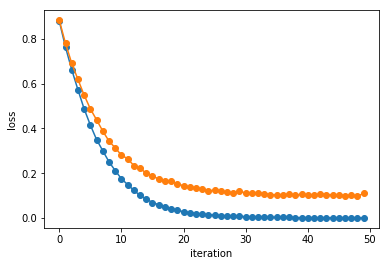

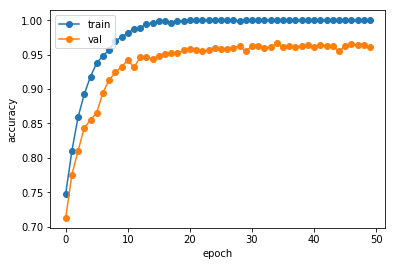

In [14]:
plt.plot(train_loss_history, '-o')
plt.plot(val_loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [15]:
#TEST
test_acc = 0.0
test_running_loss = 0.0

best_model.eval()
for i, (test_inputs, test_targets) in enumerate(test_loader):
    test_inputs, test_targets = Variable(test_inputs), Variable(test_targets)

    if torch.cuda.is_available():
        test_inputs, test_targets = test_inputs.cuda(), test_targets.cuda().long()

    # forward
    test_outputs = best_model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)

    # print statistics
    test_running_loss += test_loss.item()

    _, test_preds = torch.max(test_outputs, 1)

    test_acc += np.mean((test_preds == test_targets).data.cpu().numpy())

test_acc /= i + 1
test_running_loss /= i + 1

print('Test loss: %.3f,  Test acc: %.3f' %
          (test_running_loss,  test_acc))

Test loss: 1.994,  Test acc: 0.391
